In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

!rm -rf 80-629
!git clone https://github.com/lcharlin/80-629/
import sys
sys.path += ['80-629/week2-Fundamentals/']

# We import several home functions in order to create graphics
from utilities import scatter_plot, plot_polynomial_curves, plot_optimal_curve, train_poly_and_see, MSE
%matplotlib inline

# Week \#2 - Machine Learning Fundamentals - Exercices

This tutorial will focus on three important aspects of machine learning (ML), namely the capacity of models, the notions of bias and variance of an estimator as well as a brief introduction to cross-validation. The goal is to develop basic intuition of these concepts through a series of short exercises.

## 2.1 Model capacity

Informally, the capacity of a model can be defined as the number of functions a model can fit. Lower-capacity models would be able to perfectly fit (i.e., obtain 0 train error) less functions then higher-capacity models. 

Higher-capacity models are generally more prone to **overfitting**. Overfitting occures when the gap between the test and training error is large, or in other words when models memorize properties of the training set that are not usefull for (i.e. do not generalize to) performing predictions on a test set.

Intuitively, when two models fit the training data equally well, usually the model with less capacity will generalize better, i.e. have lower test error. Thus, as rule of thumb we perfom similar decision rules over more complex ones. (extra: this is a good illustration of https://en.wikipedia.org/wiki/Occam%27s_razor)

### 2.1.1 Data generation

Let's first simulate some data! In this section, every observation $y$ is generated according to the following model:

$$ y = x \cos(x / \gamma) + \epsilon$$

where $y \in \mathbb{R}$ is the ouptut, $x \in \mathbb{R}$ are the features, $\gamma$ is the period of the cosine function and $\epsilon$ is the random noise such as $\epsilon \sim \mathcal{N}(0, \sigma^2)$ where $\sigma$ is defined by YOU.

In [2]:
def data_simulation(sample_size, scale, period, variance):
    
    x = np.random.uniform(-scale, scale, sample_size)
    x.sort()
    noise = np.random.normal(0, variance, sample_size)
    y = x * np.cos(x / period) + noise
    
    return x, y

Whenever it is possible, it is always a good idea idea to visualize the data (in order to get some intuition about it). 

**Question**: Play with the parameters (*variance*, *scale* and *period*) and see how they affect the plot.

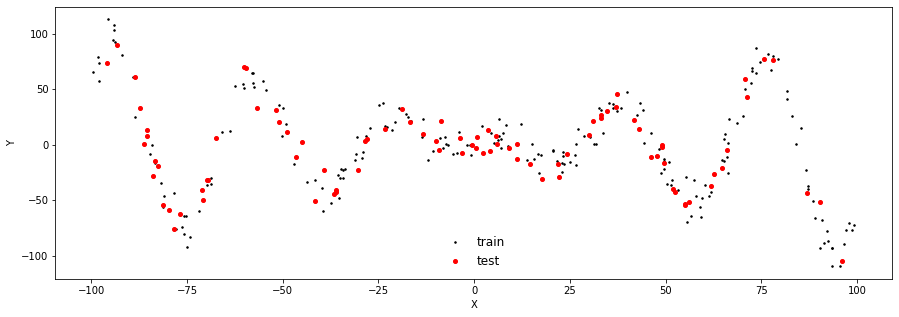

In [3]:
sample_size = 300
variance = 10   # Variance of the Gaussian noise
scale = 100   # Range
period = 6   # Simulation are based on cosinus function (see data_simulation function)

x_train, y_train = data_simulation(int(.7*sample_size), scale, period, variance)
x_test, y_test = data_simulation(int(.3*sample_size), scale, period, variance)

plt = scatter_plot(x_train, x_test, y_train, y_test)   # The scatter_plot function is in the utilities script

### 2.1.2 Getting - visual - intuition about models' capacity

As seen in class (Slide 29 for example), the higher is the capacity of the model, the better it will fit the training data set (caution though, fitting well the training data does not necesarily lead to good generalization). Here, we use [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression) to fit the training set (don't worry, the purpose of the tutorial is not to understand polynomial regression). Note however that the greater is the polynomial degree, the higher is the model capacity. 

**Questions**: 
1. Observe how the fitted curve behave with respect to their polynomial degre. 
2. Would you prefer to fit the data points with polynomial regression of degre 25 or 100?
3. Wich of these curves should have the best generalization error?

**Answers**:

As the degre increase, the associated polynomial curve looks as an polynomial interpolation.
Looking at the dataset (first Figure, Section 2.1.1), we can see at first sight a maximum of 15 local minima/maxima. This being said, polynomial regression with degre 100 seems overkill (to much capacity).
The MSE on the test set (see below) prove us right: polynomial regression of degre 20 seems to generalize than the polynomial regression of degre 100.

Polynomial degre:  0  | MSE train: 2054.8743  | MSE test: 1365.618
Polynomial degre:  1  | MSE train: 1922.1061  | MSE test: 1437.8416
Polynomial degre:  3  | MSE train: 1648.3416  | MSE test: 1344.9958
Polynomial degre:  5  | MSE train: 1294.7118  | MSE test: 1076.043
Polynomial degre:  10  | MSE train: 943.9794  | MSE test: 917.2376
Polynomial degre:  20  | MSE train: 93.469  | MSE test: 128.1975
Polynomial degre:  150  | MSE train: 84.7988  | MSE test: 135.4392


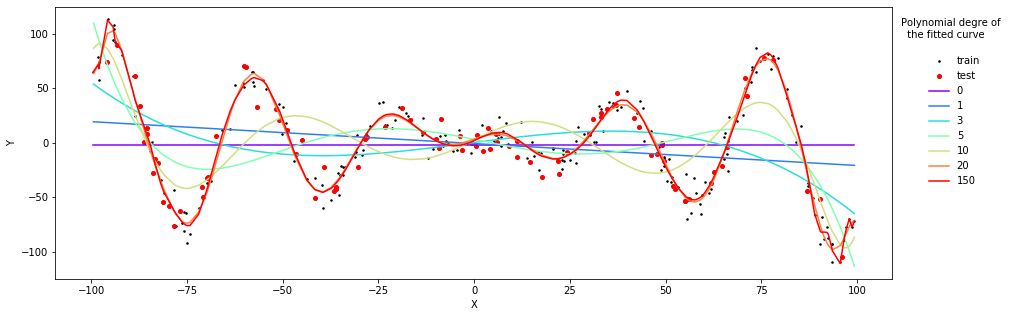

In [4]:
degre = [0, 1, 3, 5, 10, 20, 150]   # Maximal polynomial degre of the fitted curve: higher degre == higher capacity

plot_polynomial_curves(x_train, x_test, y_train, y_test, degre)

### 2.1.3 Sample size and models' capacity

We study the behavior of the polynomial regressors and examine how they perform when the sample size increases (as presented on Slide 32). Specificaly, with study the behavior of the cubic polynomial regression and the optimal polynomial regression (which minimize the MSE on the test set). 

**Question**: Do the following curves behave as expected?

**Answer**: Yes! Without running the experiment, we should expect that:

1. The MSE on the test set decrease as the train set gets larger.
3. The training and the test curves overlap as the training set gets larger. 
2. Cubic polynomial regression has a greater MSE (than the optimal model) on both training and test sets given a large enough training set (say $n > 100$ for example).

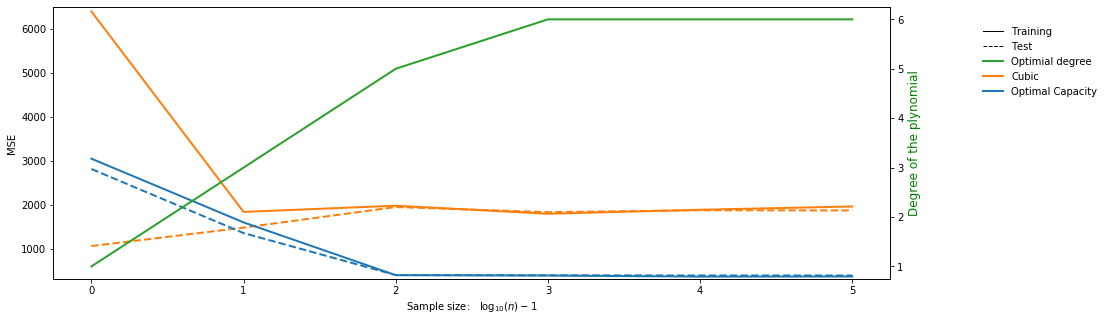

In [5]:
sample_size = [10, 10**2, 10**3, 10**4, 10**5, 10**6]   # Sample size of the training set that we want to study
variance = 20

H_train, H_test, optimal_train, optimal_test, optimal_degre \
    = train_poly_and_see(sample_size, scale, period, variance, degre)

plot_optimal_curve(optimal_train, optimal_test, H_train, H_test, optimal_degre)

# 2.2 Bias and variance of estimators

We will now explore some properties of the bias and the variance of well known estimators.

##  Linear models for regression

The polynomial curve fitting problem encountered previously is an instance of a broader class of models - linear models. More specifically, it is a linear regression task, where the goal is to predict a value of one or more continuous target variables given the values of some input variables. Linear models share the property of **being a linear function of the adjustable parameters** (polynomial coefficients in case of polynomial models). This simple form of linear regression models are also linear functions of the input variables. Linear models have been studied in depth by statisticians in the last century and their theory is well understood. 

In addition we hypothesize that our loss function is the squared error (i.e., ( $\sum_{i=0}^n (y_i - \hat{y}_i)^2$ ). We will study some properties of this model and loss function. 

A linear regression model fitted with a squared error is also known as an ordinary least square (OLS) regression.

First, let's simulate some data.

### 2.2.1 Data simulation

In this section, every observation $y$ is generated according to the following model:

$$ y = \bf{x}^\top \bf{w} + \epsilon$$

where $y \in \mathbb{R}$ is the ouptut, $\bf{x}$ is the vector of covariates,  $\bf{w}$ is the vector of the associated weights and $\epsilon$ is the random noise such as $\epsilon \sim \mathcal{N}(0,1)$.

In [6]:
def data_simulation(sample_size, w_0, w_1):
    
    x = np.random.uniform(-1, 10, sample_size)
    x.sort()
    noise = np.random.normal(0, 1, sample_size)
    y = w_0 + w_1 * x + noise
    
    return x, y

According to the above model formulation, we can sample the data and visualize it.

<module 'matplotlib.pyplot' from '/Users/lcharlin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

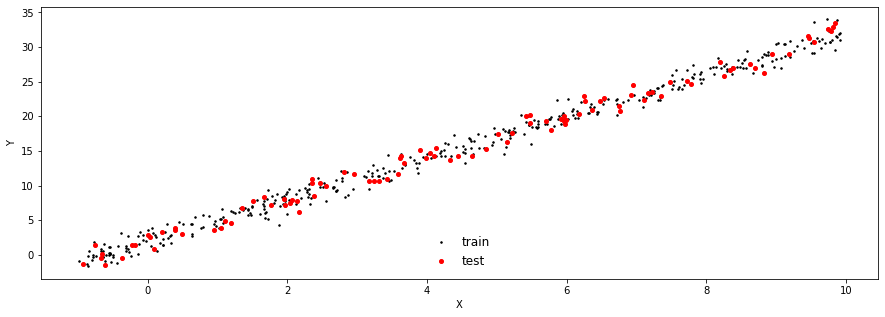

In [7]:
w_0, w_1 = 2, 3   # Fix w values
sample_size = 500   # Fix the sample size - train

X, y = data_simulation(sample_size, w_0, w_1)
X = [np.ones(len(y)), X]
X = np.asarray(X ).T

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scatter_plot(X_train[:, 1], X_test [:, 1], y_train, y_test) 

### 2.2.2 The OLS estimators

**Questions**: 
1. Given the expression of the least squares estimators presented on slide 24 of the course, complete the OLS function below to obtain the least squares estimators. As a reminder, these estimators are defined as follows:

$$ \hat{\bf{w}}^{\text{OLS}} := (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}$$

where $\bf{X}$ is the [design matrix](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.) and $\bf{y}$ is the outputs vector.

2. Derive the estimators associated with the previously simulated data.

*Remark*: Do not forget to calculate the intercept $\bf{w}_0$. This being said and according to the above OLS function, simply fill the first column of design matrix with ones as explictly suggest [here](https://en.wikipedia.org/wiki/Design_matrix#:~:text=In%20statistics%2C%20a%20design%20matrix,specific%20values%20for%20that%20object.).

**Answer**:

In [8]:
def OLS(X, y):
    
    A = np.linalg.inv(np.dot(X.T, X))
    B = np.dot(X.T, y)
    
    return np.dot(A, B)

w_ols = OLS(X_train, y_train)

**Question**: Make predictions on training and test sets and compute the associated MSE. are the results obtained those hoped for?

**Answer**:

In [9]:
# Train set
y_hat_train = np.dot(X_train, w_ols)

# Test set
y_hat_test = np.dot(X_test, w_ols)

print('MSE of the train: ', MSE(y_hat_train, y_train))
print('MSE of the test:  ', MSE(y_hat_test, y_test))

MSE of the train:  0.953596876663307
MSE of the test:   1.0586539824904981


#### 2.2.2.1 Bias of the OLS estimators

**Question**: Calculate the bias of the estimators.

**Answer**:

In [10]:
bias = w_ols - [w_0, w_1]

print("Bias of w_0: ", bias[0])   # Bias of w_0
print("Bias of the w_1: ", bias[1])   # Bias of w_1

Bias of w_0:  0.005673458403705922
Bias of the w_1:  -9.300740351658732e-05


**Question**: Does it make sense?

**Answer**: Indeed! Since the OLS estimator in the contexrt of a linear regression unbiased:

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{OLS}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= \bf{w}
\end{align}

**Question**: How could we reduce the observed bias of the OLS estimators?

**Answer**: In this specific context, one gentle way would be to simply increase the sample size. Try it! Fix the sample size to $n = 100k$ and observe how the empirical biases behave (run everything from Section 2.2.1 with sample_size fixed to 100k).

In [11]:
sample_size = 10**6

#### 2.2.2.2 Variance of the OLS estimators

The OLS estimators calculated in the last section have no fixed values and are actually [random variables](https://en.wikipedia.org/wiki/Random_variable). It follows that these estimators have variance. This variance can be estimated in several ways. In this tutorial, we propose to estimated the variance of the OLS estimators in two different ways. The firs approach use [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method#Use_in_mathematics) and the second one simply use [theoretical properties of the variance](https://en.wikipedia.org/wiki/Variance#Properties).


#### Monte Carlo methods

Don't be intimidated by the name, basic Monte Carlo methods are rather simple! As far as we are concerned, we can compute the variance of the OLS estimators in 4 easy steps.

**Question**: Complete the code below according to the commentaries.

**Answer**:

In [12]:
mc_estimates = 100   # Fix the number of Monte Carlo estimates that you want to run
M = np.zeros((mc_estimates, 2))   # Initialize a matrix where you will store the estimators

# Step 1: Create a for loop 
for k in np.arange(mc_estimates):
    
    # Step 2: Data simulation
    x, y = data_simulation( int(.8 * sample_size), w_0, w_1)
    
    X = [np.ones(len(y)), x]   
    X = np.asarray(X).T
    
    # Step 3: OLS estimates
    w_ols = OLS(X, y)
    M[k, :] = w_ols   # Store the estimators
    
# Step 4: Compute the variance (hint: np.var)
var = np.var(M, axis=0)
print("MC estimate of the variance of the w_0 estimate: ", var[0])   # Variance of w_0
print("MC estimate of the variance of the w_1 estimate: ",var[1])   # Variance of w_1

MC estimate of the variance of the w_0 estimate:  4.235769954468428e-06
MC estimate of the variance of the w_1 estimate:  1.3215639654788777e-07


#### Analytical approach

If we cannot compute the MC estimators, we can sometimes derive the analytical expression of the variance of the estimators. Indeed, the variance of the OLS is:

\begin{align}
    \text{Var}(\hat{\bf{w}}^{\text{OLS}}) 
    &= \text{Var}\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{y}\right) && \text{Definition of the OLS estimators}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y})\left((\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \right)^\top && \text{Property of the variance on matrices} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var} (\bf{y}) \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the transpose}  \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{X} \bf{w} + \bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Modelization of the data}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \text{Var}(\bf{\epsilon}) \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Property of the variance (only $\epsilon$ is a random variable)} \\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top \bf{I} \ \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top && \text{Since $\epsilon$ is iid}\\
    &= (\bf{X}^\top \bf{X})^{-1} \bf{X}^\top  \bf{X}\left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= \left((\bf{X}^\top \bf{X})^{-1} \right)^\top \\
    &= (\bf{X}^\top \bf{X})^{-1} && \text{Since $\bf{X}^\top \bf{X}$ is symetric and by property of the inverse of a matrix}
\end{align}

**Question**: Compute the variance of the OLS estimators according to the above expression.

**Answer**:

In [13]:
# Computation
var = np.linalg.inv(np.dot(X_train.T, X_train))

# Interest
print("Analytical variance of the w_0 estimate: ", var[0, 0])   
print("Analytical variance of the w_1 estimate: ",var[1, 1])   

Analytical variance of the w_0 estimate:  0.006900954415728657
Analytical variance of the w_1 estimate:  0.00023542536980931998


**Question**: Are the last results make sense according to the the MC estimate previously calculated?

**Answer**: Yes! The analytical estimates of the variance of the OLS estimators are approximately the same as those obtained by MC methods.

### 2.2.3 OLS estimators with L2-Regularization

As pointed out in slide 36, we can add a L$_2$ regularization on the weights of the linear model defined in Section 2.1. The associated estimators are known as the [Ridge or Tikhonov estimator](https://en.wikipedia.org/wiki/Tikhonov_regularization) and are defined as

$$ \hat{w}^{\text{ridge}} := (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}$$

where $\lambda$ is a hyperparameter (see slides 37 and 38) wich control the model's capacity. 

**Question**: Given the above expression, complete the ridge function below to obtain the ridge estimators.

**Answer**:

In [14]:
def ridge(X, y, lambda_hp):
    
    A = np.linalg.inv(np.dot(X.T, X) + lambda_hp * np.identity(X.shape[1]))
    B = np.dot(X.T, y)
    
    return np.dot(A, B)

**Question**: Compute the ridge estimators for different values of $\lambda$. But first, try to understand how the ridge estimator will behave according to these 3 scenarios:

1. For $\lambda = 0$. 
2. For $\lambda = 10^10$.
3. How the estimators generally behave according to $\lambda$? 

**Answers**:

1. The ridge estimators are equivalent to the OLS estimators.
2. The ridge estimators should collapse.
3. Experiment by yourself (or look at slide 37 ;)).

In [15]:
lambda_hp = 10**3
w_ridge = ridge(X_train, y_train, lambda_hp)

**Question**: Make predictions on training and test sets. Are they better than the predictions made by the OLS estimators?

**Answer**:

In [16]:
# Train set
y_hat_train = np.dot(X_train, w_ridge)

# Test set
y_hat_test = np.dot(X_test, w_ridge)

#### 2.2.3.1 Bias of the ridge estimators

**Question**: Calculate the bias of the estimators.

**Answer**:

In [17]:
bias = w_ridge - [w_0, w_1]

print("Bias of w_0: ", bias[0])   # Bias of w_0
print("Bias of the w_1: ", bias[1])   # Bias of w_1

Bias of w_0:  -1.3660211222899425
Bias of the w_1:  -0.04941578866296181


**Question**: Compare the bias of the ridge estimators with those of the OLS. Does it make sense?

**Answer**: Ridge estimators are biased. Hence, the empirical bias of those estimators should be greater than those of the OLSs. We can see that the Rigde estimators are biased. We can see that the Rigde estimators are biased. 

\begin{align}
    \mathbb{E}[\hat{\bf{w}}^{\text{ridge}}] 
    &= \mathbb{E}[(\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{y}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \mathbb{E}[\bf{X} \bf{w} + \bf{\epsilon}] \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \mathbb{E}[\bf{X} \bf{w}] + \mathbb{E}[\bf{\epsilon}] \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \{ \bf{X} \bf{w} + \bf{O} \} \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{X}^\top \bf{X} \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I} - \lambda \bf{I} ) \bf{w}  \\
    &= (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} (\bf{X}^\top \bf{X} + \lambda \bf{I}) \bf{w} -  (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1}\lambda \bf{I} \bf{w}  \\
    &=  \bf{w} -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}.
\end{align}

Hence, the bias of the ridge estimator is:
$$ \text{Bias}(\hat{\bf{w}}^{\text{ridge}})   = -  \lambda (\bf{X}^\top \bf{X} + \lambda \bf{I})^{-1} \bf{w}  $$

Note that under classical assumption, its empirical bias is always be greater than the one associated to the OLS estimator.

**Remark**: One question remains: how can choose the hyper parameter value $\lambda$ of the ridge estimator? The following section will suggest an answer.

## 2.3 Cross validation - Getting the optimal hyper parameter value

Cross validation can be used (among other techniques) in order to perform model and hyper parameters selection. The first step is to split the train set into a (smaller) train set and validation set as shown in Slide 38 of the course. In Python, we will mostly use the train_test_split function from the Scikitlearn library to perform data splitting.

In [18]:
X_sub_train, X_validation, y_sub_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

We now study the performance (according to the MSE) of the ridge estimators given a grid of hyper paramater values. 

**Question**: Complete the cross validation procedure below. 

In [19]:
losses_stack_sub_train, losses_stack_train, losses_stack_validation, losses_stack_test = [], [], [], []

for lambda_hp in np.arange(0, 100, 1):
    
    # Learn the associated parameters (w) associated with the specifc lambda
    w_ridge_cv = ridge(X_sub_train, y_sub_train, lambda_hp)
    
    # Make prediction for the sub_train set and the validation set
    y_hat_sub_train = np.dot(X_sub_train, w_ridge_cv)
    y_hat_validation = np.dot(X_validation, w_ridge_cv)
    
    # Stacking statistics
    losses_stack_sub_train.append(MSE(y_sub_train, y_hat_sub_train))
    losses_stack_validation.append(MSE(y_validation, y_hat_validation))
    
    # Pay attention to the following steps !!!
    w_ridge = ridge(X_train, y_train, lambda_hp)
    y_hat_train = np.dot(X_train, w_ridge)
    y_hat_test = np.dot(X_test, w_ridge)

    losses_stack_train.append(MSE(y_train, y_hat_train))
    losses_stack_test.append(MSE(y_test, y_hat_test))

We can now select to optimal hyperparameter $\lambda$. The optimal value will minimize the loss function on the validation set (as presented on Slides 31 and 44). Note that the selection of the optimal hyper parameter will never be based on the its behavior on the test set!

The optimal regularization is 5


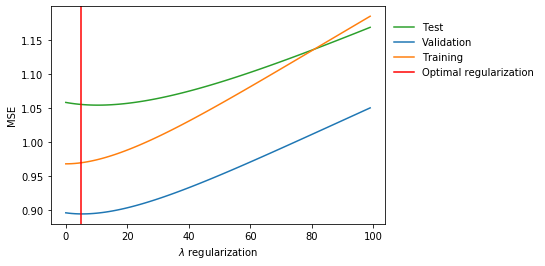

In [20]:
cmap = plt.get_cmap("tab10")

plt.plot(losses_stack_test, label='Test', color=cmap(2))
plt.plot(losses_stack_validation, label='Validation', color=cmap(0))
plt.plot(losses_stack_sub_train, label='Training', color=cmap(1))

plt.axvline(x=np.argmin(losses_stack_validation),color='red', label='Optimal regularization')

plt.xlabel('$\lambda$ regularization')
plt.ylabel('MSE')
leg = plt.gca().legend(loc='center left', bbox_to_anchor=(1, .8))
leg.get_frame().set_alpha(0)
print('The optimal regularization is', np.argmin(losses_stack_validation))

After all this work, it could be interesting to compare the ridge estimator to the OLS estimator on the test set.

In [21]:
print('TRAIN: OLS estimators:   ', losses_stack_train[0])
print('TRAIN: ridge estimators: ', losses_stack_train[np.argmin(losses_stack_validation)])

print('\nTEST: OLS estimators:   ', losses_stack_test[0])
print('TEST: ridge estimators: ', losses_stack_test[np.argmin(losses_stack_validation)])

TRAIN: OLS estimators:    0.953596876663307
TRAIN: ridge estimators:  0.9546286601642657

TEST: OLS estimators:    1.0586539824904981
TEST: ridge estimators:  1.0556804927938122


## 2.4 Take home messages - Final remarks

1. Model with high capacity don't necessary have a lower generalization error.
2. Unbiased estimator don't necessary have a lower generalization error.
3. In the specific case where the loss function is based on the MSE, we can decompose the generalization error with respect to the bias and the variance of the associated estimators.
4. Cross validation procedure can be tricky! Be sure to understand the code snippet in Section 2.3!